# PSTAT 135 Final Project

## Swinging the Vote: Logistic Regression for Predicting Voter Turnout in Swing States

**Group 22: Bernie Graves, Brandelyn Nie, Brian Che, Matthew Balderrama**

## Introduction

Our objective for this project is to determine how aspects of individual voters’ socioeconomic status (SES), consisting of their income, education, financial security, accessibility to resources, and the like, influence how they decide to vote in the general or primary elections. It’s notable that societal influences and their living conditions, especially when living in certain politicized areas, may have a heavy effect on voter turnout for elections taking place so we’ve decided to explore any existing patterns from the state data provided. The datasets we chose to work with are states that are classified as “swing states,” meaning any state that could reasonably be won by either the Democratic or Republican candidate in a statewide election. The states we selected are *Michigan*, *Florida*, *Arizona*, and *Nevada*.

Given that we are working with swing states, there is a level of uncertainty among voters that could be utilized in assisting the final decision for the election winner. From these analyses we would be able to find which groups that election candidates may want to focus their campaigns on. Essentially, determining which groups candidates may want to target in order to sway voters and increase voter turnout in favor of their candidacy/respective parties. Additionally, there are specific trends we may be able to derive from our main research questions, such as how one’s ownership of property or access to housing, their highest level of education received, and even their age or gender can reflect one’s party alignment or voting tendencies.               

## Research Questions

Thus, our main research question and secondary questions are:

<font size="4">*How does socioeconomic background (education, income, ethnicity, etc ) affect voter turnout?*</font>
- <font size="3">*How does property (household, land) ownership affect voter turnouts or patterns?*</font>
- <font size="3">*How does education level relate to voter alignment or patterns?*</font>
- <font size="3">*How would age and gender relate to voter alignment or patterns?*</font>

# Import Libraries

In [2]:
import pyspark as spark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
spark = SparkSession.builder \
        .appName("Model") \
        .config("spark.sql.debug.maxToStringFields", 1000) \
        .getOrCreate()

# Import state data

In [4]:
gcs_path = 'gs://pstat135-voter-file/VM2Uniform'

nv =  spark.read.parquet(gcs_path + "/" + "VM2Uniform--NV--2021-06-13")
fl = spark.read.parquet(gcs_path + "/" + "VM2Uniform--FL--2021-05-19")
mi =  spark.read.parquet(gcs_path + "/" + "VM2Uniform--MI--2021-01-30")
az =  spark.read.parquet(gcs_path + "/" + "VM2Uniform--AZ--2021-05-20")

## EDA

### Michigan EDA

#### Property Ownership and Voter Turnout

In [5]:
land_cols = ["General_2020", "Voters_Age", "Voters_Gender","County", "Voters_Active",
                 "CommercialData_DwellingType",
                    "Voters_VotingPerformanceEvenYearGeneral", "ElectionReturns_G18CountyTurnoutRepublicans",
                   "ElectionReturns_G18CountyTurnoutIndependentsAllOthers", 
                   "ElectionReturns_G18CountyTurnoutDemocrats",
                   "ElectionReturns_P18CountyTurnoutAllRegisteredVoters",
                   "ElectionReturns_G16CountyTurnoutRepublicans",
                   "ElectionReturns_G16CountyTurnoutIndependentsAllOthers", 
                   "ElectionReturns_G16CountyTurnoutDemocrats",
                   "ElectionReturns_P16CountyTurnoutAllRegisteredVoters",
                   "Residence_Addresses_Property_LandSq_Footage",
                   "Residence_Addresses_Property_HomeSq_Footage",
                    "CommercialDataLL_Gun_Owner",
                    "CommercialDataLL_Interest_in_Religious_Inspirational_In_Household",
                    "Parties_Description"              
                   ]

mi_pd = mi.select(*land_cols).sample(True, 0.005, 123).toPandas()

In [6]:
mi_pd = mi_pd.sample(10000, random_state=123)

mi_pd["State"] = "MI"

all_pd = mi_pd

all_pd['ElectionReturns_G18CountyTurnoutRepublicans'] = pd.to_numeric(all_pd['ElectionReturns_G18CountyTurnoutRepublicans'].str.replace(r'%', ''))
all_pd['ElectionReturns_G18CountyTurnoutDemocrats'] = pd.to_numeric(all_pd['ElectionReturns_G18CountyTurnoutDemocrats'].str.replace(r'%', ''))
all_pd['ElectionReturns_G16CountyTurnoutRepublicans'] = pd.to_numeric(all_pd['ElectionReturns_G16CountyTurnoutRepublicans'].str.replace(r'%', ''))
all_pd['ElectionReturns_G16CountyTurnoutDemocrats'] = pd.to_numeric(all_pd['ElectionReturns_G16CountyTurnoutDemocrats'].str.replace(r'%', ''))
all_pd["Voters_Age"] = pd.to_numeric(all_pd["Voters_Age"])
all_pd["Residence_Addresses_Property_LandSq_Footage"] = pd.to_numeric(all_pd["Residence_Addresses_Property_LandSq_Footage"])

The first idea we explored was the effect property ownership has on turnout. To do this, we selected the Residence_Addresses_Property_LandSq_Footage variable to see how it varies by party.

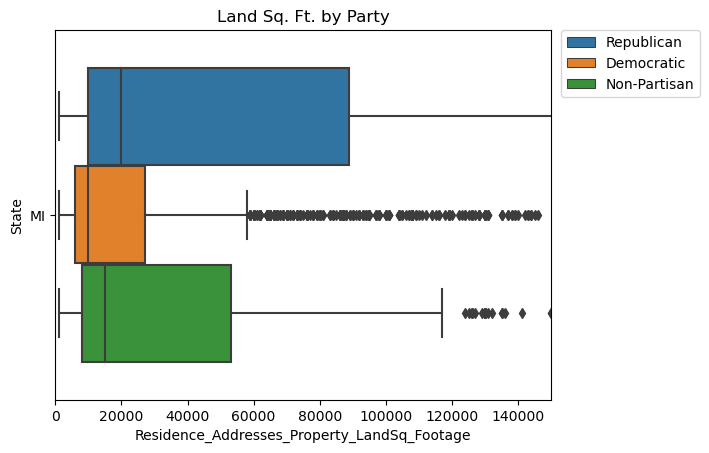

In [7]:
land_plot = sns.boxplot(data=all_pd, x="Residence_Addresses_Property_LandSq_Footage", y="State", hue="Parties_Description")
land_plot.set(title="Land Sq. Ft. by Party")
land_plot.set_xlim(0, 150000)
land_plot = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

land_plot

<AxesSubplot:xlabel='CommercialData_DwellingType', ylabel='count'>

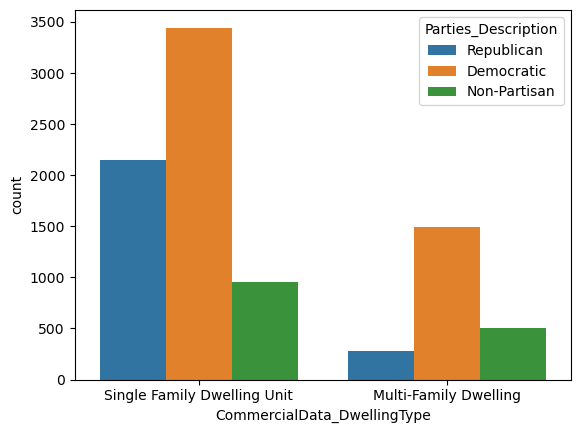

In [8]:
dwelling_plot = sns.countplot(data = all_pd, x = "CommercialData_DwellingType", hue="Parties_Description")

dwelling_plot

In [9]:
mi_party_tot = mi.groupBy("Parties_Description").count().sort("Parties_Description")

mi_vote_party = mi.groupBy("Parties_Description", "General_2020").count().sort("Parties_Description")

mi_dem_tot = mi_party_tot.filter(mi_party_tot.Parties_Description == "Democratic").head()[1]
mi_np_tot = mi_party_tot.filter(mi_party_tot.Parties_Description == "Non-Partisan").head()[1]
mi_rep_tot = mi_party_tot.filter(mi_party_tot.Parties_Description == "Republican").head()[1]

In [10]:
dwelling_df = mi.groupby("CommercialData_DwellingType", "Parties_Description").count()\
.dropna().sort("CommercialData_DwellingType", "Parties_Description")

dwelling_df = dwelling_df.withColumn("Percent of Party", F.when(dwelling_df["Parties_Description"] == "Democratic",
                                                              F.round(dwelling_df["count"] / mi_dem_tot, 3))
                                                            .when(dwelling_df["Parties_Description"] == "Republican",
                                                              F.round(dwelling_df["count"] / mi_rep_tot, 3))
                                                            .otherwise(F.round(dwelling_df["count"] / mi_np_tot, 3)))

dwelling_df.show()

+---------------------------+-------------------+-------+----------------+
|CommercialData_DwellingType|Parties_Description|  count|Percent of Party|
+---------------------------+-------------------+-------+----------------+
|       Multi-Family Dwel...|         Democratic|1133172|           0.272|
|       Multi-Family Dwel...|       Non-Partisan| 401772|           0.289|
|       Multi-Family Dwel...|         Republican| 212633|           0.104|
|       Single Family Dwe...|         Democratic|2551588|           0.613|
|       Single Family Dwe...|       Non-Partisan| 727595|           0.524|
|       Single Family Dwe...|         Republican|1678748|           0.822|
+---------------------------+-------------------+-------+----------------+



This initial plot is telling us that Republicans tend to have more land in the State of Michigan. The second plot is telling us that Republicans have a higher proportion of people living in Single Family Dewlling housing. There is over a 20% difference and it could be contributing factor to voting tendancies. Now let's see how voter turnout differs between parties. We are interested in the presidential elections, so we are looking at voter turnout from 2016.

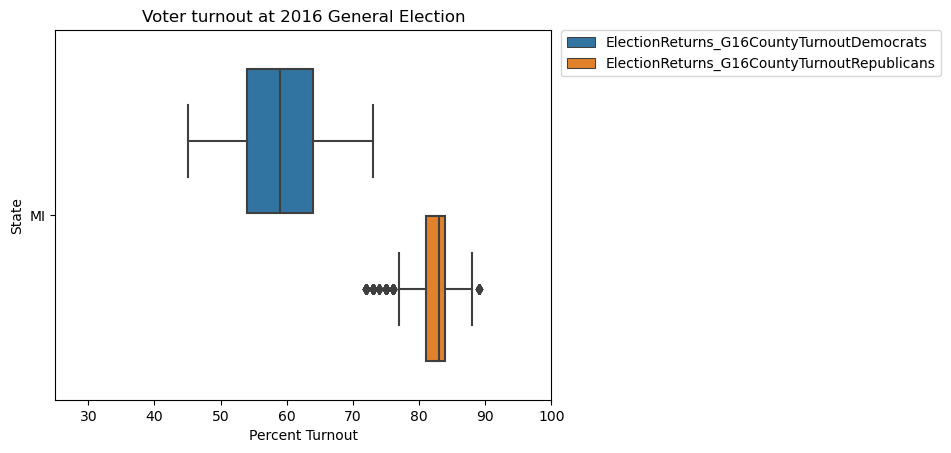

In [11]:
turnout_2016 = all_pd[["ElectionReturns_G16CountyTurnoutDemocrats", "ElectionReturns_G16CountyTurnoutRepublicans", "State"]]
turnout_2016 = pd.melt(turnout_2016, id_vars="State", value_vars=["ElectionReturns_G16CountyTurnoutDemocrats", "ElectionReturns_G16CountyTurnoutRepublicans"])

turnout_2016_plot = sns.boxplot(data=turnout_2016, x="value", y="State", hue="variable")
turnout_2016_plot.set(title="Voter turnout at 2016 General Election", xlabel="Percent Turnout")
turnout_2016_plot.set_xlim(25,100)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [12]:


mi_vote_party = mi_vote_party.withColumn("Total_Voted_General_2020", mi_vote_party["count"])
mi_vote_party = mi_vote_party.withColumn("Party_Total", F.when(mi_vote_party.Parties_Description == "Democratic",
                                                            mi_dem_tot)
                                                        .when(mi_vote_party.Parties_Description == "Non-Partisan",
                                                            mi_np_tot)
                                                        .when(mi_vote_party.Parties_Description == "Republican",
                                                            mi_rep_tot))

mi_vote_party = mi_vote_party.withColumn("Percent_Voted", F.round(mi_vote_party.Total_Voted_General_2020 / mi_vote_party.Party_Total, 3))
mi_vote_party = mi_vote_party.withColumn("State", F.lit("MI"))
mi_vote_party = mi_vote_party.drop("count")

mi_vote_party = mi_vote_party.filter(mi_vote_party.General_2020 == "Y").drop("General_2020")

In [13]:
mi_vote_party.show()

+-------------------+------------------------+-----------+-------------+-----+
|Parties_Description|Total_Voted_General_2020|Party_Total|Percent_Voted|State|
+-------------------+------------------------+-----------+-------------+-----+
|         Democratic|                 2894091|    4164138|        0.695|   MI|
|       Non-Partisan|                  763418|    1388458|         0.55|   MI|
|         Republican|                 1738843|    2041055|        0.852|   MI|
+-------------------+------------------------+-----------+-------------+-----+



In this swing state that is Michigan, we see about a 15% difference in the median turnout in 2018 between Democrats and Republicans. We also see Non-Partisans having the lowest percent voted at 55%. There seems to be some sort of relationship between land, party and whether or not someone voted.

### Florida EDA

In [14]:
# first pull out columns of interest
interest_cols = ["General_2020",
                 "CommercialData_Education",
                 "Voters_Age", "Voters_Gender",
                 "Residence_Addresses_Property_LandSq_Footage",
                 "Parties_Description", 
                 "CommercialData_EstimatedHHIncomeAmount"                           
]

df_sub=fl.select("General_2020",
                 "CommercialData_Education",
                 "Voters_Age", "Voters_Gender",
                 "Residence_Addresses_Property_LandSq_Footage",
                 "Parties_Description", 
                 "CommercialData_EstimatedHHIncomeAmount")

df_sub.printSchema()

root
 |-- General_2020: string (nullable = true)
 |-- CommercialData_Education: string (nullable = true)
 |-- Voters_Age: string (nullable = true)
 |-- Voters_Gender: string (nullable = true)
 |-- Residence_Addresses_Property_LandSq_Footage: string (nullable = true)
 |-- Parties_Description: string (nullable = true)
 |-- CommercialData_EstimatedHHIncomeAmount: string (nullable = true)



#### Sample
For visualization of the data, we will need to take a sample of the data to be able to process these plots. Summaries will be done with the entire dataset to ensure the plots are what is intended.

In [15]:
# randomly take a sample of the data frame and convert to pandas
fl_pd = fl.select(*interest_cols).sample(True, 0.01, 123).toPandas()

In [16]:
# now take a 10000 subset of the pandaDF
fl_pd = fl_pd.sample(10000, random_state=123)

fl_pd["State"] = "FL"

fl_pd.head()

,General_2020,CommercialData_Education,Voters_Age,Voters_Gender,Residence_Addresses_Property_LandSq_Footage,Parties_Description,CommercialData_EstimatedHHIncomeAmount,State
138895,None,None,62,F,None,Non-Partisan,$30220,FL
82444,Y,None,54,M,0043000,Democratic,$53299,FL
61288,Y,Grad Degree - Extremely Likely,43,F,None,Democratic,$72000,FL
137977,Y,None,55,F,0013000,Registered Independent,$69916,FL
41335,Y,None,65,M,0014000,Republican,$87318,FL


#### Age and Party

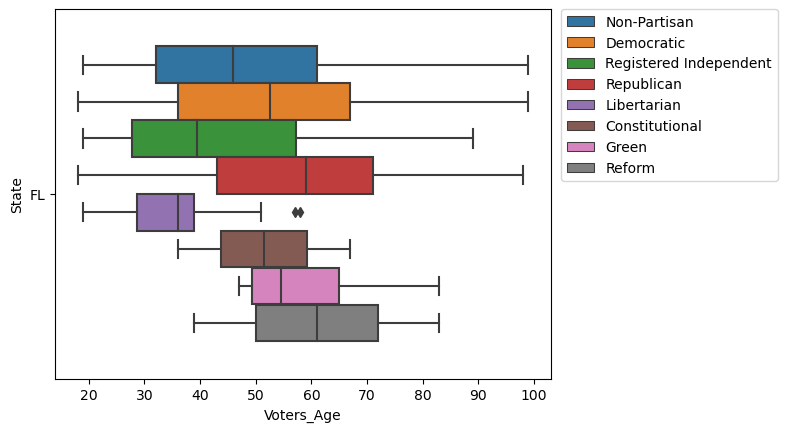

In [17]:
fl_pd['Voters_Age']=pd.to_numeric(fl_pd['Voters_Age'])

ageplot_fl = sns.boxplot(data=fl_pd, x="Voters_Age", y="State",hue="Parties_Description")
ageplot_fl = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ageplot_fl

In [18]:
ageFL = fl.select("Voters_Age",'Parties_Description')
ageFL.groupBy('Parties_Description').agg(F.mean('Voters_Age'), F.count('Voters_Age').alias('Voters_in_Party')).show(10)

+--------------------+------------------+---------------+
| Parties_Description|   avg(Voters_Age)|Voters_in_Party|
+--------------------+------------------+---------------+
|          Republican| 55.78978141797492|        4994235|
|Registered Indepe...| 45.94540307883206|         180523|
|               Other| 39.66997026759167|           1009|
|         Libertarian|40.406567493665804|          39863|
|               Green|39.804321404456445|           7405|
|              Reform| 50.80409556313993|           1465|
|      Constitutional|47.140307907627715|           2858|
|          Democratic|51.874933047463514|        5186510|
|           Socialist| 31.86215334420881|           1226|
|        Non-Partisan| 47.31178927220779|        3741851|
+--------------------+------------------+---------------+



### Arizona EDA

In [19]:
selected_interest = [ "General_2020", "General_2016","General_2018", "PresidentialPrimary_2020","PresidentialPrimary_2016",
                 "Voters_Age", "Voters_Gender", "County", "CountyEthnic_Description", "Voters_Active", "CommercialData_EstimatedHHIncomeAmount",
                   "Voters_VotingPerformanceEvenYearGeneral", 
                   "ElectionReturns_G18CountyTurnoutRepublicans",
                   "ElectionReturns_G18CountyTurnoutIndependentsAllOthers", 
                   "ElectionReturns_G18CountyTurnoutDemocrats",
                   "ElectionReturns_P18CountyTurnoutAllRegisteredVoters",
                   "ElectionReturns_G16CountyTurnoutRepublicans",
                   "ElectionReturns_G16CountyTurnoutIndependentsAllOthers", 
                   "ElectionReturns_G16CountyTurnoutDemocrats",
                   "ElectionReturns_P16CountyTurnoutAllRegisteredVoters",
                   "Residence_Addresses_Property_LandSq_Footage",
                   "Residence_Addresses_Property_HomeSq_Footage",
                   "Parties_Description", 
                   "VoterParties_Change_Changed_Party",
                   "CommercialData_EstimatedHHIncome",
                   "CommercialData_AreaMedianEducationYears",
                   "CommercialDataLL_Household_Primary_Language",
                 "CommercialDataLL_Business_Owner",
                     "CommercialData_EstimatedAreaMedianHHIncome"
]

In [20]:
az_pd = az.select(*selected_interest).sample(True, 0.05, 123).toPandas()
az_pd = az_pd.sample(50000, random_state=123)
az_pd["State"] = "AZ"

In [21]:
az_pd['ElectionReturns_G18CountyTurnoutRepublicans'] = pd.to_numeric(az_pd['ElectionReturns_G18CountyTurnoutRepublicans'].str.replace(r'%', ''))
az_pd['ElectionReturns_G18CountyTurnoutDemocrats'] = pd.to_numeric(az_pd['ElectionReturns_G18CountyTurnoutDemocrats'].str.replace(r'%', ''))
az_pd['ElectionReturns_G16CountyTurnoutRepublicans'] = pd.to_numeric(az_pd['ElectionReturns_G16CountyTurnoutRepublicans'].str.replace(r'%', ''))
az_pd['ElectionReturns_G16CountyTurnoutDemocrats'] = pd.to_numeric(az_pd['ElectionReturns_G16CountyTurnoutDemocrats'].str.replace(r'%', ''))

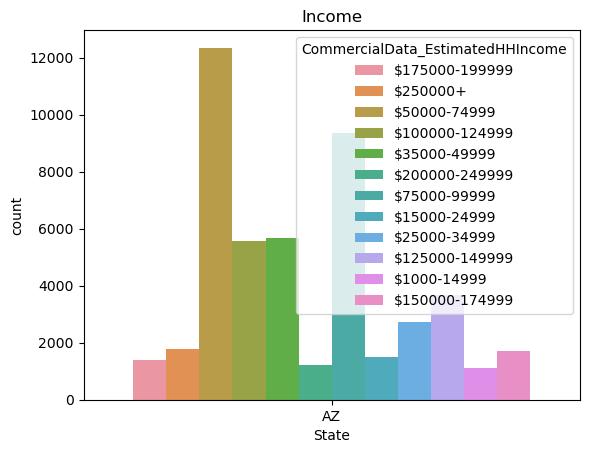

In [22]:
income_chart_az = sns.countplot(data=az_pd, x="State",
                             hue="CommercialData_EstimatedHHIncome").set(title="Income")

From our sample, we can see that most voters turned out to be those whose income falls in the category of 'middle-class' This makes sense since the majority of adults in American make up the middle-class in terms of income.

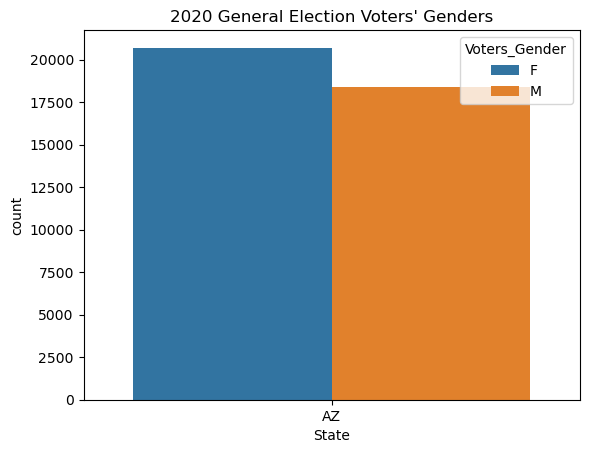

In [23]:
az_voted2020 = az_pd[az_pd["General_2020"] == "Y"]
gender_chart_az = sns.countplot(data=az_voted2020, x="State",
                             hue="Voters_Gender").set(title="2020 General Election Voters' Genders")

In our sample, we see that females were voting more than males in Arizona in the 2020 General Election.

### Nevada EDA

In [24]:
target_cols = ['Voters_Age',
               'Voters_Gender',
               'Parties_Description',
               'General_2020',
               'Ethnic_Description',
               'CommercialData_Education',
               'CommercialData_DwellingType',
               'CommercialData_AreaMedianHousingValue',
               'CommercialData_AreaMedianEducationYears',
              'CommercialData_EstimatedHHIncomeAmount'
              ]

nv_df = nv.select(*target_cols)

In [25]:
nv_pd = nv_df.toPandas()
nv_pd['CommercialData_AreaMedianEducationYears'] = pd.to_numeric(nv_pd['CommercialData_AreaMedianEducationYears'])

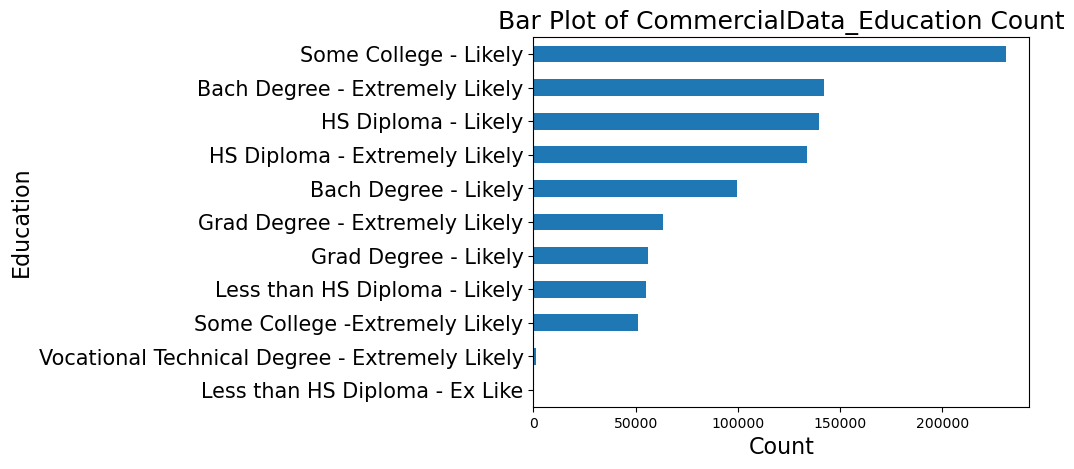

In [26]:
edu_plot = nv_pd['CommercialData_Education'].value_counts().sort_values(ascending=True)

# create a boxplot of the value counts
edu_plot = edu_plot.plot.barh()
edu_plot.set_yticklabels(edu_plot.get_yticklabels(), fontsize=15)
edu_plot.set_xlabel('Count', fontsize=16)
edu_plot.set_ylabel('Education', fontsize=16)
edu_plot.set_title('Bar Plot of CommercialData_Education Count', fontsize=18)
plt.show()

We observe that that the `CommercialData_Education` level of the Nevada voter data that is most prominent is "Some College - Likely" for over 200,000 while "Vocational Degree - Extremely Likely" and "Less than HS Diploma - Extremely likely" has a count around 0.

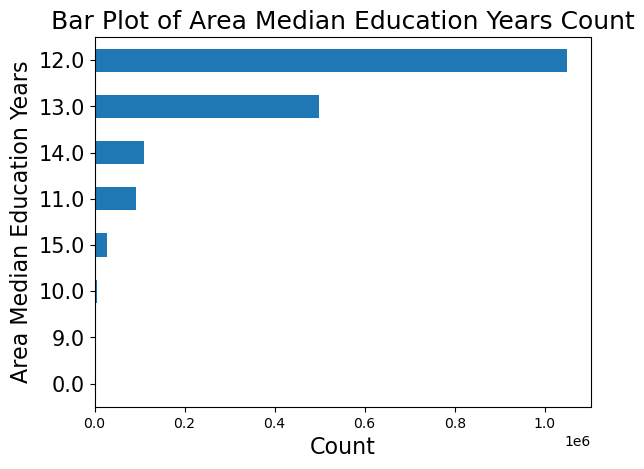

In [27]:
edu_yrs = nv_pd['CommercialData_AreaMedianEducationYears'].value_counts().sort_values(ascending=True)

# create a boxplot of the value counts
edu_yrs = edu_yrs.plot.barh()
edu_yrs.set_yticklabels(edu_yrs.get_yticklabels(), fontsize=15)
edu_yrs.set_xlabel('Count', fontsize=16)
edu_yrs.set_ylabel('Area Median Education Years', fontsize=16)
edu_yrs.set_title('Bar Plot of Area Median Education Years Count', fontsize=18)
plt.show()

The `CommercialData_AreaMedianEducationYears` displays 12 years to have a count over 1 million, which is over half the total amount of Nevada voters.We can asssume that most Nevada voters are from areas where completing high school education is the median of the level of education.

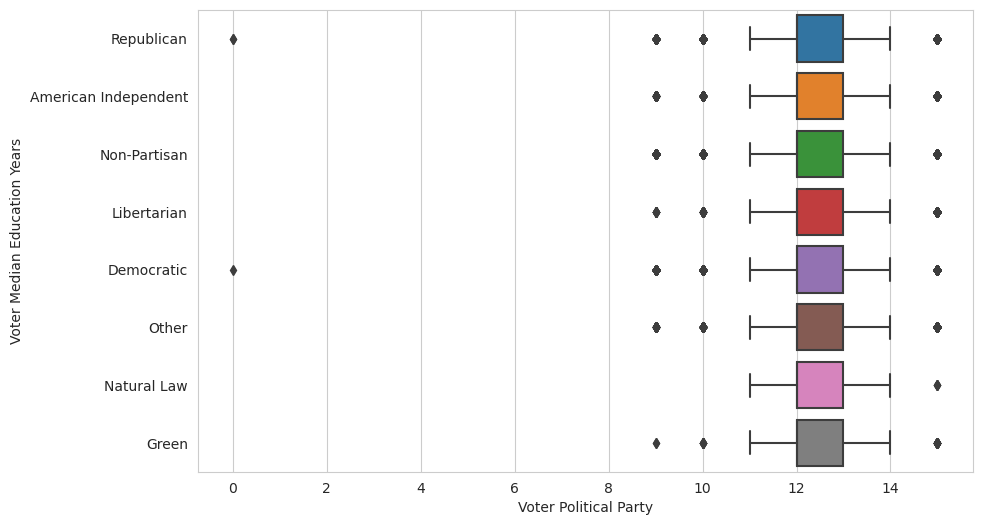

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(10,6))

# education
sns.boxplot(x='CommercialData_AreaMedianEducationYears', y='Parties_Description', data=nv_pd)

ax.set_xlabel('Voter Political Party')
ax.set_ylabel('Voter Median Education Years')

plt.show()

There is little to no variance in the boxplots displayed across political parties among the Nevada voter data as the Interquartile Range begins at 12 and ends with 13, which matches our previous bar plot visualization with 12 years being the most prominent area median education years.

## Modeling

After some exploratory analysis in these 4 swing states, we decided on our variables for our model.

Our variables of focus:
- `General_2020` — The response variable (label column) determining voter turnout by *Y* as *1* and *null* as *0*
- `Voters_Age` — Age of individual voter
- `Voters_Gender` — Gender of individual voter (*M*, *F*)
- `Parties_Description` — Political parties active in the state (*Democratic*, *Republican*, *Non-Partisan*, ...)
- `Ethnic_Description` — Ethnicity of individual voter ()
- `CommercialData_Education` — Categorical likelihood scale of voter level of education from HS Diploma to Graduate Degree
- `CommercialData_DwellingType` — Dwelling type of individual voter (*Single-family*, *Multi-family*)
- `CommercialData_AreaMedianHousingValue` — Median housing value from individual voter's area
- `CommercialData_AreaMedianEducationYears` — Median education years from individual voter's area (*0*, *3*, *10*, *11*, ...)
- `CommercialData_EstimatedHHIncomeAmount` — Estimated household income amount of individual voter

We specifically chose `General_2020` as our response variable because we're interested in voting behaviors during the most recent presidential election year in swing states. We will use a Logistic Regression model for each state separately then intrepret the variables to see if their are any similarities or differences in voter behaviour in swing states. With this we hope to develop a model that can predict whether or not someone will vote so that certain people or groups can be targetted.

### Data Preparation

In [29]:
target_cols = ['Voters_Age',
               'Voters_Gender',
               'Parties_Description',
               'General_2020',
               'Ethnic_Description',
               'CommercialData_Education',
               'CommercialData_DwellingType',
               'CommercialData_AreaMedianHousingValue',
               'CommercialData_AreaMedianEducationYears',
              'CommercialData_EstimatedHHIncomeAmount'
              ]

nv_df = nv.select(*target_cols)
fl_df = fl.select(*target_cols)
mi_df = mi.select(*target_cols)
az_df = az.select(*target_cols)

In [30]:
from pyspark.sql.functions import regexp_replace, col, when

# Define processing function for cleaning
def process_df(df):
    # Create a list of the columns to update
    columns_to_update = ["CommercialData_AreaMedianHousingValue", "CommercialData_EstimatedHHIncomeAmount"]

    # Loop through each column and update the value
    for column in columns_to_update:
        df = df.withColumn(
            column, 
            regexp_replace(col(column), "\\$", "")
        )

    # Cast the following columns to IntegerType
    columns_to_cast = ["Voters_Age",
                       "CommercialData_AreaMedianEducationYears",
                       "CommercialData_AreaMedianHousingValue",
                       "CommercialData_EstimatedHHIncomeAmount"
                      ]

    for col_name in columns_to_cast:
        df = df.withColumn(
            col_name, 
            df[col_name].cast(IntegerType())
        )

    # Create a new column called "label" based on the value of "General_2020"
    df = df.withColumn("label", 
                             when(df.General_2020 == "Y", 1).otherwise(0)
                            )

    # Remove the "General_2020" column and any rows with missing values
    df = df.drop("General_2020").dropna()
    
    return df

In [31]:
nv_df = process_df(nv_df)

nv_df.printSchema()

root
 |-- Voters_Age: integer (nullable = true)
 |-- Voters_Gender: string (nullable = true)
 |-- Parties_Description: string (nullable = true)
 |-- Ethnic_Description: string (nullable = true)
 |-- CommercialData_Education: string (nullable = true)
 |-- CommercialData_DwellingType: string (nullable = true)
 |-- CommercialData_AreaMedianHousingValue: integer (nullable = true)
 |-- CommercialData_AreaMedianEducationYears: integer (nullable = true)
 |-- CommercialData_EstimatedHHIncomeAmount: integer (nullable = true)
 |-- label: integer (nullable = false)



In [32]:
fl_df = process_df(fl_df)

fl_df.printSchema()

root
 |-- Voters_Age: integer (nullable = true)
 |-- Voters_Gender: string (nullable = true)
 |-- Parties_Description: string (nullable = true)
 |-- Ethnic_Description: string (nullable = true)
 |-- CommercialData_Education: string (nullable = true)
 |-- CommercialData_DwellingType: string (nullable = true)
 |-- CommercialData_AreaMedianHousingValue: integer (nullable = true)
 |-- CommercialData_AreaMedianEducationYears: integer (nullable = true)
 |-- CommercialData_EstimatedHHIncomeAmount: integer (nullable = true)
 |-- label: integer (nullable = false)



In [33]:
mi_df = process_df(mi_df)

mi_df.printSchema()

root
 |-- Voters_Age: integer (nullable = true)
 |-- Voters_Gender: string (nullable = true)
 |-- Parties_Description: string (nullable = true)
 |-- Ethnic_Description: string (nullable = true)
 |-- CommercialData_Education: string (nullable = true)
 |-- CommercialData_DwellingType: string (nullable = true)
 |-- CommercialData_AreaMedianHousingValue: integer (nullable = true)
 |-- CommercialData_AreaMedianEducationYears: integer (nullable = true)
 |-- CommercialData_EstimatedHHIncomeAmount: integer (nullable = true)
 |-- label: integer (nullable = false)



In [34]:
az_df = process_df(az_df)

az_df.printSchema()

root
 |-- Voters_Age: integer (nullable = true)
 |-- Voters_Gender: string (nullable = true)
 |-- Parties_Description: string (nullable = true)
 |-- Ethnic_Description: string (nullable = true)
 |-- CommercialData_Education: string (nullable = true)
 |-- CommercialData_DwellingType: string (nullable = true)
 |-- CommercialData_AreaMedianHousingValue: integer (nullable = true)
 |-- CommercialData_AreaMedianEducationYears: integer (nullable = true)
 |-- CommercialData_EstimatedHHIncomeAmount: integer (nullable = true)
 |-- label: integer (nullable = false)



### Split Train/Testing Data 

In [35]:
# Nevada split
nv_train_df, nv_test_df = nv_df.randomSplit([0.7, 0.3], seed=43)

# Florida split
fl_train_df, fl_test_df = fl_df.randomSplit([0.7, 0.3], seed=43)

# Michigan split
mi_train_df, mi_test_df = mi_df.randomSplit([0.7, 0.3], seed=43)

# Arizona split
az_train_df, az_test_df = az_df.randomSplit([0.7, 0.3], seed=43)

### Set up pipeline stages

In [36]:
# Import necessary libraries
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

# Define string indexer for categorical features
categorical_cols = ['Voters_Gender',
                    'Parties_Description',
                    'Ethnic_Description', 
                    'CommercialData_DwellingType', 
                    'CommercialData_Education'
                   ]

In [37]:
# Pipeline Stage: StringIndexer

# Import necessary libraries
from pyspark.ml.feature import StringIndexer

# Define string indexer for categorical features
categorical_cols = ['Voters_Gender',
                    'Parties_Description',
                    'Ethnic_Description', 
                    'CommercialData_DwellingType', 
                    'CommercialData_Education'
                   ]

indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="skip") for col in categorical_cols]

In [38]:
# Pipeline Stage: OneHotEncoder

# Define one-hot encoder for categorical features
encoders = [OneHotEncoder(inputCol=col+"_index", outputCol=col+"_vec") for col in categorical_cols]

In [39]:
# Pipeline Stage: Assembler

# Define assembler for all features
assembler = VectorAssembler(inputCols=["Voters_Age",
                                       "CommercialData_AreaMedianHousingValue",
                                       "CommercialData_AreaMedianEducationYears",
                                       "CommercialData_EstimatedHHIncomeAmount"] 
                            + [col+"_vec" for col in categorical_cols], outputCol="features")

### Define Logistic Regression Model & Pipeline

In [40]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
# Define logistic regression model
lr = LogisticRegression(featuresCol="features", labelCol="label")

# Define the pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, lr])

In [41]:
nv_pipeline_model = pipeline.fit(nv_train_df)
nv_train_predictions = nv_pipeline_model.transform(nv_train_df)
nv_test_predictions = nv_pipeline_model.transform(nv_test_df)

23/03/22 20:26:30 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/03/22 20:26:30 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [42]:
fl_pipeline_model = pipeline.fit(fl_train_df)
fl_train_predictions = fl_pipeline_model.transform(fl_train_df)
fl_test_predictions = fl_pipeline_model.transform(fl_test_df)

In [43]:
mi_pipeline_model = pipeline.fit(mi_train_df)
mi_train_predictions = mi_pipeline_model.transform(mi_train_df)
mi_test_predictions = mi_pipeline_model.transform(mi_test_df)

In [41]:
az_pipeline_model = pipeline.fit(az_train_df)
az_train_predictions = az_pipeline_model.transform(az_train_df)
az_test_predictions = az_pipeline_model.transform(az_test_df)

23/03/22 21:20:04 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/03/22 21:20:04 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


## Interpreting Our Model

In [43]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate the performance of the model
evaluator = BinaryClassificationEvaluator(labelCol="label")

In [46]:
nv_auc_train = evaluator.evaluate(nv_train_predictions)
nv_auc_test = evaluator.evaluate(nv_test_predictions)

# Print the AUC score
print("Training AUC score: {:.2f}%".format(nv_auc_train * 100))
print("Test AUC score: {:.2f}%".format(nv_auc_test * 100))

Training AUC score: 72.26%
Test AUC score: 72.38%


In [47]:
fl_auc_train = evaluator.evaluate(fl_train_predictions)
fl_auc_test = evaluator.evaluate(fl_test_predictions)

# Print the AUC score
print("Training AUC score: {:.2f}%".format(fl_auc_train * 100))
print("Test AUC score: {:.2f}%".format(fl_auc_test * 100))

Training AUC score: 70.32%
Test AUC score: 70.32%


In [48]:
mi_auc_train = evaluator.evaluate(mi_train_predictions)
mi_auc_test = evaluator.evaluate(mi_test_predictions)

# Print the AUC score
print("Training AUC score: {:.2f}%".format(mi_auc_train * 100))
print("Test AUC score: {:.2f}%".format(mi_auc_test * 100))

Training AUC score: 72.46%
Test AUC score: 72.39%


In [44]:
az_auc_train = evaluator.evaluate(az_train_predictions)
az_auc_test = evaluator.evaluate(az_test_predictions)

# Print the AUC score
print("Training AUC score: {:.2f}%".format(az_auc_train * 100))
print("Test AUC score: {:.2f}%".format(az_auc_test * 100))

Training AUC score: 73.76%
Test AUC score: 73.54%


In [ ]:
auc_dict = {
    'State': ['Nevada', 'Florida', 'Michigan',' Arizona'],
    'Train AUC': [nv_auc_train, fl_auc_train, mi_auc_train, az_auc_train],
    'Test AUC': [nv_auc_test, fl_auc_test, mi_auc_test, az_auc_test]
}

auc_df = pd.DataFrame(auc_dict)

print(auc_df)

      State  Train AUC  Test AUC
0    Nevada   0.722599  0.723753
1   Florida   0.703205  0.703215
2  Michigan   0.724634  0.723893
3   Arizona   0.737616  0.735385


We observe that our logistic reegression model results in a training AUC score of around 70% throughout all state's in both the training AUC andd testing AUC with its best performance with the Arizona voter dataset at a test AUC of 73.54%. These scores reflect that our model performs relatively well with the input columns provided to predicting voter turnout in the General 2020 election, which we'll be exploring further in the ranked coefficients.

In [ ]:
# names of columns used to make feature vector, and then stored in pandaDF
featureCols = pd.DataFrame(nv_train_predictions.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+
  nv_train_predictions.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

featureCols = featureCols.set_index('idx')

In [ ]:
# Retrieve the logistic regression model from the pipeline
lr_model = nv_pipeline_model.stages[-1]

nv_coefsArray = np.abs(np.array(lr_model.coefficients))  # convert to np.array
nv_coefsDF = pd.DataFrame(nv_coefsArray, columns=['coefs'])  # to pandas

nv_coefsDF = nv_coefsDF.merge(featureCols, left_index=True, right_index=True)  # join it with featureCols we created above
nv_coefsDF.sort_values('coefs', inplace=True)  # Sort them
nv_coefsDF.head()

,coefs,name
1,0.000001,CommercialData_AreaMedianHousingValue
3,0.000002,CommercialData_EstimatedHHIncomeAmount
0,0.024626,Voters_Age
69,0.032187,Ethnic_Description_vec_Luxembourgian
4,0.123826,Voters_Gender_vec_F


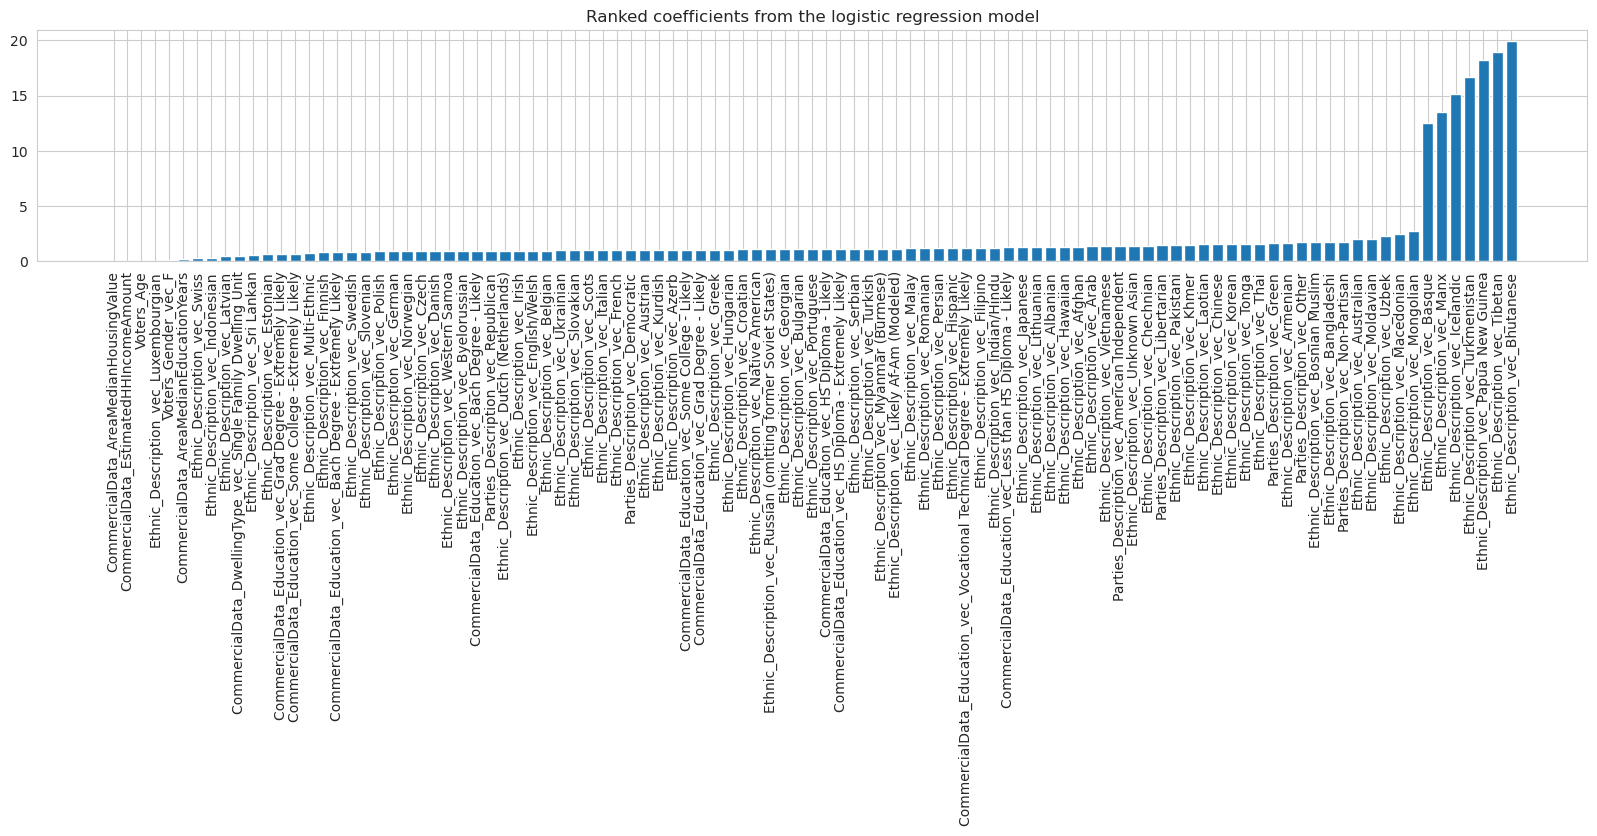

In [ ]:
plt.rcParams["figure.figsize"] = (20,3)

plt.xticks(rotation=90)
plt.bar(nv_coefsDF.name, nv_coefsDF.coefs)
plt.title('Ranked coefficients from the logistic regression model')
plt.show()

In [ ]:
# Retrieve the logistic regression model from the pipeline
lr_model = fl_pipeline_model.stages[-1]

fl_coefsArray = np.abs(np.array(lr_model.coefficients))  # coflert to np.array
fl_coefsDF = pd.DataFrame(fl_coefsArray, columns=['coefs'])  # to pandas

fl_coefsDF = fl_coefsDF.merge(featureCols, left_index=True, right_index=True)  # join it with featureCols we created above
fl_coefsDF.sort_values('coefs', inplace=True)  # Sort them
fl_coefsDF.head()

,coefs,name
1,6.431543e-07,CommercialData_AreaMedianHousingValue
3,3.437078e-06,CommercialData_EstimatedHHIncomeAmount
0,2.659961e-02,Voters_Age
84,6.806562e-02,Ethnic_Description_vec_Bhutanese
2,1.070027e-01,CommercialData_AreaMedianEducationYears


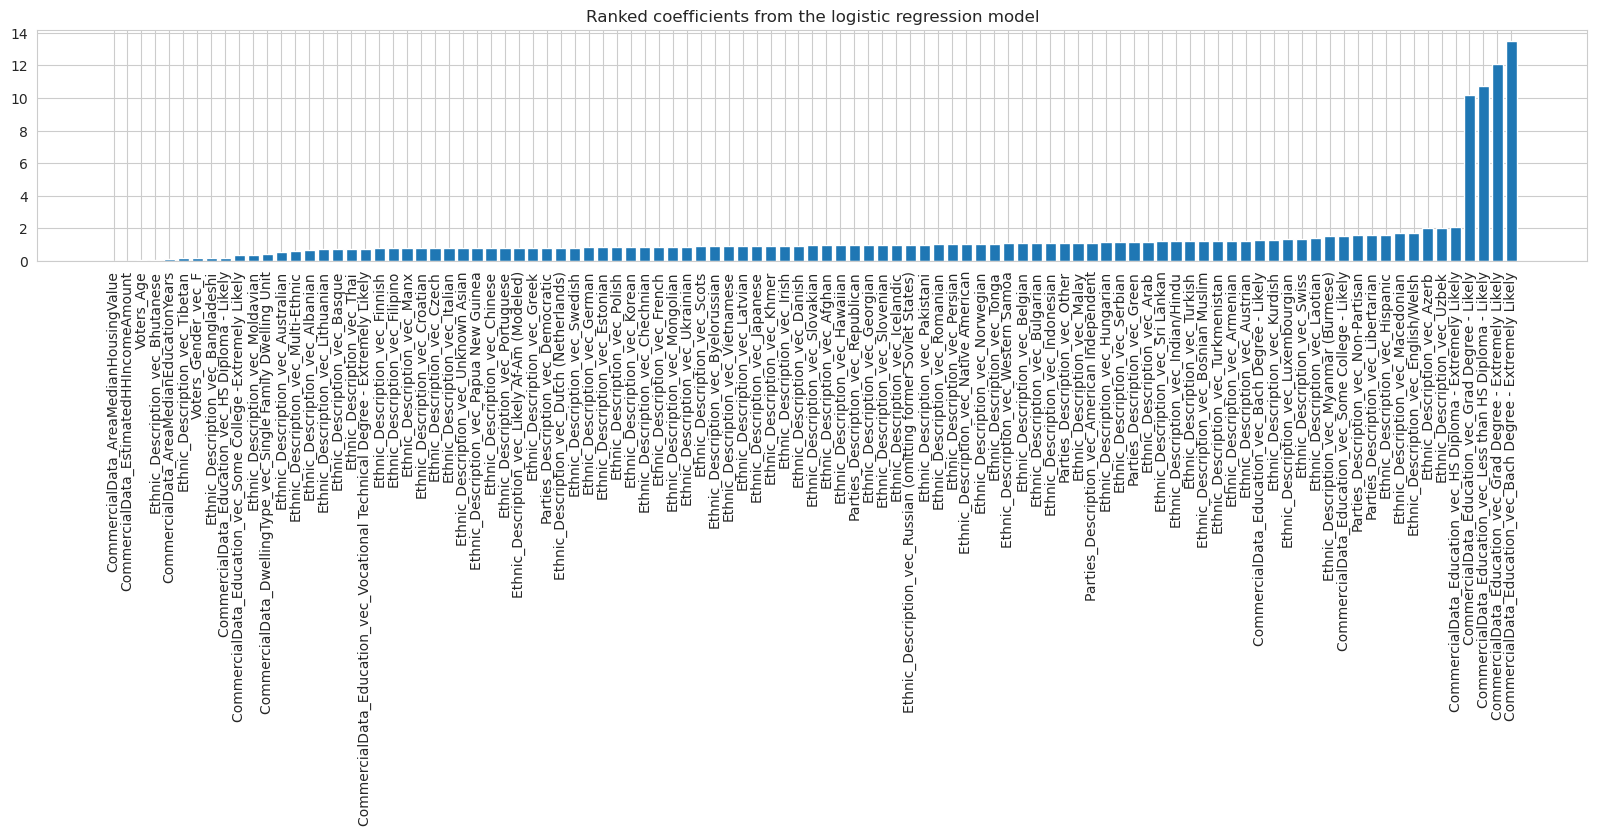

In [ ]:
plt.rcParams["figure.figsize"] = (20,3)

plt.xticks(rotation=90)
plt.bar(fl_coefsDF.name, fl_coefsDF.coefs)
plt.title('Ranked coefficients from the logistic regression model')
plt.show()

In [ ]:
# Retrieve the logistic regression model from the pipeline
lr_model = mi_pipeline_model.stages[-1]

mi_coefsArray = np.abs(np.array(lr_model.coefficients))  # comiert to np.array
mi_coefsDF = pd.DataFrame(mi_coefsArray, columns=['coefs'])  # to pandas

mi_coefsDF = mi_coefsDF.merge(featureCols, left_index=True, right_index=True)  # join it with featureCols we created above
mi_coefsDF.sort_values('coefs', inplace=True)  # Sort them
mi_coefsDF.head()

,coefs,name
1,0.000002,CommercialData_AreaMedianHousingValue
3,0.000005,CommercialData_EstimatedHHIncomeAmount
0,0.022326,Voters_Age
2,0.133747,CommercialData_AreaMedianEducationYears
4,0.188895,Voters_Gender_vec_F


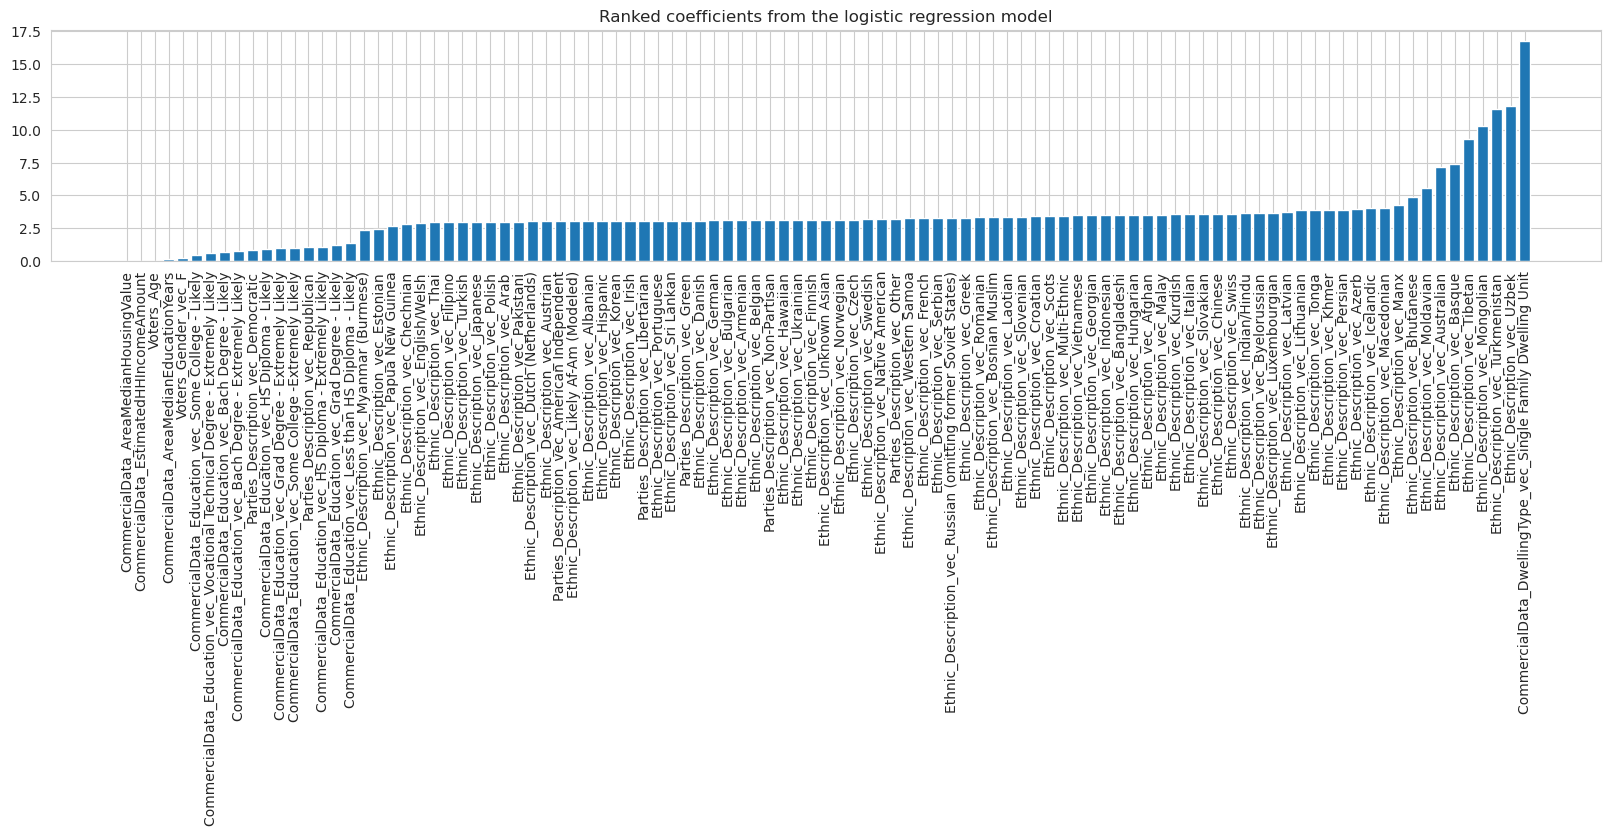

In [ ]:
plt.rcParams["figure.figsize"] = (20,3)

plt.xticks(rotation=90)
plt.bar(mi_coefsDF.name, mi_coefsDF.coefs)
plt.title('Ranked coefficients from the logistic regression model')
plt.show()

In [ ]:
# Retrieve the logistic regression model from the pipeline
lr_model = az_pipeline_model.stages[-1]

az_coefsArray = np.abs(np.array(lr_model.coefficients))  # coazert to np.array
az_coefsDF = pd.DataFrame(az_coefsArray, columns=['coefs'])  # to pandas

az_coefsDF = az_coefsDF.merge(featureCols, left_index=True, right_index=True)  # join it with featureCols we created above
az_coefsDF.sort_values('coefs', inplace=True)  # Sort them
az_coefsDF.head()

,coefs,name
1,8.585927e-07,CommercialData_AreaMedianHousingValue
3,2.865485e-06,CommercialData_EstimatedHHIncomeAmount
0,2.157681e-02,Voters_Age
4,1.493984e-01,Voters_Gender_vec_F
2,1.630663e-01,CommercialData_AreaMedianEducationYears


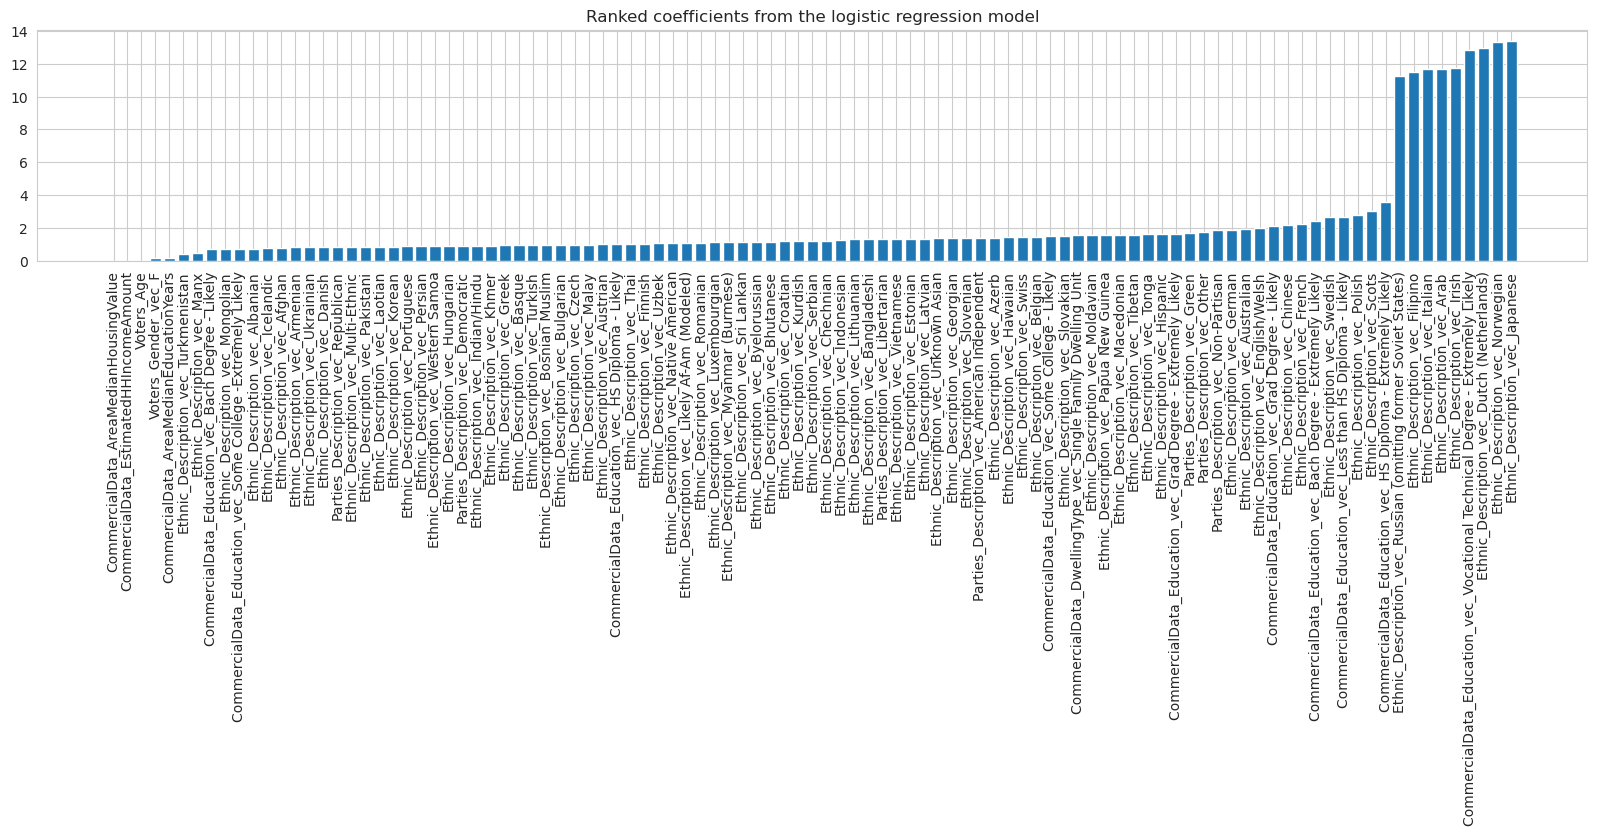

In [ ]:
plt.rcParams["figure.figsize"] = (20,3)

plt.xticks(rotation=90)
plt.bar(az_coefsDF.name, az_coefsDF.coefs)
plt.title('Ranked coefficients from the logistic regression model')
plt.show()

**Age and Gender**

Let’s take into consideration the coefficient rankings for `Voter_Age` and `Voter_Gender` across the four swing states considered. Note that `Voter_Gender` is a categorical variable and a voter being male is considered as the baseline variable and does not appear in the rank plots.  
Across all four swing states, the `Voter_Age` coefficient has a very low rank, interestingly enough all are third to last, and thus are not a huge contributor in seeing if a voter went to vote or not in the 2020 primaries. On the other hand, for the `Voter_Gender`, in Nevada the coefficient is ranked 5th to last, Florida 7th to last, Michigan 5th to last, and Arizona 4th to last. Across the board for these four swing states `Voter_Gender` is ranked very low and we again conclude that this variable does not have a huge impact on voter turnout. Florida has the highest ranking out of the four states, though this may be due to the population being larger than the other states. With this information, campaigns do not need to place huge emphasis on campaigning towards a specific age as it does not affect the outcome of the model that much. In Florida, `Voter_Gender` could be something to consider, but as it is still a low ranked variable compared to the rest, campaigns would receive better voter turnout via focusing on other predictors in the model. 

**Property Ownership**

To examine how land or property ownership affects voter tendencies in swing states, lets look at the `CommercialData_DwellingType` column. This variable has 2 possible values (`Single Family Dwelling Unit` and `Multi-Family Dwelling`) which means there will only be one coefficient in our logistic regression model corresponding to this variable. In our model, `Multi-Family Dwelling` is the base variable, so we will need to interpret the results with this in mind. In Nevada and Florida, this coefficient is small which signifies that voting behavior is similar between people in single family units and multi family units. In Arizona, we see that this coefficient is above average, which signifies that there is a difference in voting behaviors. Perhaps the most telling is Michigan, where this coefficient is the largest. This shows us that in Michigan, there is a large difference in voting patterns depending on dwelling type. Overall, this is telling us that the importance of dwelling types varies from state to state. It is for this reason that political parties must tailor their campaigns to specifically target a state’s tendencies. The Democratic party, for example, might want to focus a campaign on trying to convert republicans in single family dwellings in Michigan. A similar campaign in Nevada or Florida is unlikely to have the same effect. Knowing the role property and dwelling type play in voting behavior is important for campaign organizers to know as it will help them create more effective campaigns. 

**Education**

We can look at `CommercialData_AreaMedianEducationYears` and `CommercialData_Education` to see how education level affects voter alignment/turnout. The `CommercialData_AreaMedianEducationYears` ranked coefficient across all four states were fairly low with Nevada ranking 6th to last, Florida and Arizona 5th to last, and Michigan 4th to last. Thus, we can determine that `CommercialData_AreaMedianEducationYears` has very little impact on voter turnout. For `CommercialData_Education`, which is a categorical likelihood scale of voter level of education, the possible values are Less than HS Diploma, HS Diploma, Some College, Bach Degree, Grad Degree, Vocational Technical Degree, all with extremely likely or likely except for Vocational Technical Degree (only extremely likely). Also, Less than HS Diploma - Extremely Likely is our base variable, so it will not appear in our ranked coefficients. In Nevada, the highest coefficient out of the possible values is Less than HS Diploma - Likely, but the ranked coefficient value is not very high. The `CommercialData_Education` coefficients for Michigan are grouped together at the bottom, indicating a relatively small effect on voter turnout. However, in Florida, the top 5 coefficients are Bach Degree - EL, Grad Degree - EL, Less than HS Dipl - L, Grad Degree - L, and HS Diploma - EL respectively. Although they are not grouped together at the top like Florida, the coefficients for Arizona have relatively high coefficient values. This indicates that education level for Florida and Arizona have a high impact on voter turnout for the most part, which is the opposite of Nevada and Michigan. Also, some values may rank higher than others, such as Florida having Bach Degree - EL and Grad Degree - EL as the top 2, but HS Dipl - L over the rest of the possible values. We know that education level in Florida impacts voter turnout, but campaigns will have to pick and choose between the different education levels to gain the most voter turnout for their respective parties. 

**Income**

Let’s consider `CommercialData_AreaMedianHousingValue` and `CommercialData_EstimatedHHIncomeAmount` to examine how income and wealth factor into voter turnout. The `CommercialData_AreaMedianHousingValue` coefficient ranked the lowest for all four states. This means that the median housing value from an individual voter’s area had little to no effect on whether that individual voted or not in 2020. Interestingly enough, the second lowest for all four states happened to be the `CommercialData_EstimatedHHIncomeAmount` coefficient, so the estimated household income amount of voters did not effect the voter turnout. Overall, the data indicates that political parties should avoid voters’ income and wealth as factors for who to target in their campaigns, since there is a possibility that it will have no effect in the voter turnout.


## Conclusion

How does socioeconomic background (education, income, ethnicity, etc ) affect voter turnout?

How does property (household, land) ownership affect voter turnouts or patterns?

How does education level relate to voter alignment or patterns?

How would age and gender relate to voter alignment or patterns?

After analysis of data that answers the secondary questions, everything comes together to answer the main research question. Certain aspects of socioeconomic status play larger roles than others depending on the state, while some of them are the same throughout. The importance of type of property ownership plays out differently in each swing state, as explained earlier. The different levels of education are very highly ranked coefficients in Florida, while not in the other three states considered. So when campaigning in Florida, parties should make sure to appeal to those who have been educated. On the other hand, in Arizona, Michigan, and Nevada ethnic group coefficients are the highest ranked, and more emphasis should be placed here during campaigns. Factors such as voter age, voter gender, and income/wealth do not contribute much to the logistic models for each state, so campaigns do not need to focus more on these variables, and should instead look towards other aspects of socioeconomic status. Through this project we have considered the same explanatory variables for four different swing states in the 2020 Primary Election, and have discussed the differences between states. With this information, campaigns now know the best approaches to swing the swing states into voting for their party.